In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks


<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 constituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Getting Started- Load Python Packages

<a id='1.1'></a>
## 2.1. Install all the packages through FinRL library

In [2]:
# ## install finrl library
!pip install wrds
!pip install swig
!pip install -q condacolab
import condacolab
condacolab.install()
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


✨🍰✨ Everything looks OK!
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-n2hved6c
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-n2hved6c
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit 0477baa95bde0dc1d65c3644d5d0feba7d72fa4e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-k3qgwb7i/elegantrl_a6a282651cbc4db98fe76d9e8845dcbe
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-k3qgwb7i/elegantrl_a6a282651cbc4db98fe76d9e8845dcbe
  Resolved https://github.com/AI4Finance-Foundation/ElegantRL.git to commit 5ef11a573caeb79d1498119777dfd36bf155e14b
  Preparing metadata (setup.py) ... done



<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them.
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [3]:
import warnings
warnings.filterwarnings("ignore")

<a id='1.3.1'></a>
### 2.3.a. Colab

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from stable_baselines3.common.logger import configure

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

<a id='1.3'></a>
### 2.3.b. Local

In [5]:
# import sys
# import itertools
# import pandas as pd
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# # matplotlib.use('Agg')
# import datetime
# sys.path.append('D:\\Learning\\University\\UIT\\AI\\Projects\\AI4Finance\\FinRL')

# %matplotlib inline
# from finrl.config_tickers import DOW_30_TICKER
# from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
# from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
# from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
# from stable_baselines3.common.logger import configure

# from pprint import pprint

# import itertools

<a id='1.4'></a>
## 2.4. Create Folders

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [7]:
print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [8]:
TRAIN_START_DATE = '2010-10-19'
TRAIN_END_DATE = '2022-04-10'
TRADE_START_DATE = '2022-04-10'
TRADE_END_DATE = '2024-06-07'

In [9]:
df = YahooDownloader(start_date=TRAIN_START_DATE,
                    end_date= TRADE_END_DATE,
                    ticker_list = DOW_30_TICKER ).fetch_data()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of DataFrame:  (100813, 8)


In [10]:
df.head()

,date,open,high,low,close,volume,tic,day
0,2010-10-19,10.835714,11.206071,10.715000,9.344972,1232784000,AAPL,1
1,2010-10-19,57.669998,58.740002,56.849998,40.922401,8711800,AMGN,1
2,2010-10-19,39.389999,40.369999,39.150002,32.362942,18099000,AXP,1
3,2010-10-19,69.570000,69.959999,68.349998,54.819141,4493400,BA,1
4,2010-10-19,78.970001,79.709999,77.769997,54.989033,9857200,CAT,1


In [11]:
df.tail()

,date,open,high,low,close,volume,tic,day
100808,2024-06-06,503.649994,504.700012,497.279999,501.920013,2419600,UNH,3
100809,2024-06-06,274.799988,277.149994,274.079987,277.040009,4862400,V,3
100810,2024-06-06,41.310001,41.720001,41.139999,41.330002,10259100,VZ,3
100811,2024-06-06,15.790000,15.980000,15.680000,15.860000,7163300,WBA,3
100812,2024-06-06,67.059998,67.440002,66.769997,67.150002,13256000,WMT,3


In [12]:
df.shape

(100813, 8)

In [13]:
df.sort_values(['date','tic']).head()

,date,open,high,low,close,volume,tic,day
0,2010-10-19,10.835714,11.206071,10.715000,9.344972,1232784000,AAPL,1
1,2010-10-19,57.669998,58.740002,56.849998,40.922401,8711800,AMGN,1
2,2010-10-19,39.389999,40.369999,39.150002,32.362942,18099000,AXP,1
3,2010-10-19,69.570000,69.959999,68.349998,54.819141,4493400,BA,1
4,2010-10-19,78.970001,79.709999,77.769997,54.989033,9857200,CAT,1


In [14]:
print(f"Unique stock: {len(df['tic'].unique())}")

Unique stock: 30


In [15]:
df['tic'].value_counts()

tic
AAPL    3431
AMGN    3431
WMT     3431
WBA     3431
VZ      3431
V       3431
UNH     3431
TRV     3431
PG      3431
NKE     3431
MSFT    3431
MRK     3431
MMM     3431
MCD     3431
KO      3431
JPM     3431
JNJ     3431
INTC    3431
IBM     3431
HON     3431
HD      3431
GS      3431
DIS     3431
CVX     3431
CSCO    3431
CRM     3431
CAT     3431
BA      3431
AXP     3431
DOW     1314
Name: count, dtype: int64

# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [16]:
INDICATORS = ['macd',
            'rsi_30',
            'cci_30',
            'dx_30']

In [17]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (3430, 8)


Successfully added vix
Successfully added turbulence index


In [18]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [19]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2010-10-19,AAPL,10.835714,11.206071,10.715000,9.344972,1.232784e+09,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
1,2010-10-19,AMGN,57.669998,58.740002,56.849998,40.922401,8.711800e+06,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
2,2010-10-19,AXP,39.389999,40.369999,39.150002,32.362942,1.809900e+07,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
3,2010-10-19,BA,69.570000,69.959999,68.349998,54.819141,4.493400e+06,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
4,2010-10-19,CAT,78.970001,79.709999,77.769997,54.989033,9.857200e+06,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
5,2010-10-19,CRM,25.272499,26.342501,25.112499,25.873701,1.237120e+07,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
6,2010-10-19,CSCO,23.100000,23.180000,22.760000,15.577089,5.376940e+07,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
7,2010-10-19,CVX,83.379997,83.680000,82.139999,47.970287,9.455500e+06,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
8,2010-10-19,DIS,34.500000,34.599998,34.000000,29.727175,9.554500e+06,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0
9,2010-10-19,GS,155.139999,159.699997,154.110001,122.910034,1.449120e+07,1.0,0.0,100.0,66.666667,100.0,20.629999,0.0


In [20]:
mvo_df = processed_full.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2015-10-19 to 2023-04-10

Trading data period: 2023-04-10 to 2024-05-31


In [21]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

83781
15689


In [22]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
2888,2022-04-08,UNH,539.000000,548.969971,538.099976,530.541321,3986700.0,4.0,12.061130,65.617448,193.686993,55.992048,21.16,28.088776
2888,2022-04-08,V,214.809998,219.410004,213.080002,213.209045,5438600.0,4.0,2.152530,50.313385,30.257199,7.735539,21.16,28.088776
2888,2022-04-08,VZ,52.730000,53.680000,52.500000,46.869347,24852200.0,4.0,0.088606,56.767251,54.073783,15.562869,21.16,28.088776
2888,2022-04-08,WBA,45.180000,45.799999,44.750000,39.891632,6164900.0,4.0,-0.714997,44.428014,-65.089454,8.349712,21.16,28.088776
2888,2022-04-08,WMT,52.303333,52.803333,52.070000,50.729706,23294400.0,4.0,1.289308,67.279747,193.309669,64.407534,21.16,28.088776


In [23]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2022-04-11,AAPL,168.710007,169.029999,165.500000,163.655289,72246700.0,0.0,1.554123,48.425299,-0.955341,12.770893,24.370001,41.400535
0,2022-04-11,AMGN,253.600006,258.450012,250.149994,233.559845,2975200.0,0.0,5.087275,65.918230,169.023774,68.639680,24.370001,41.400535
0,2022-04-11,AXP,181.059998,182.440002,177.250000,172.572769,4816800.0,0.0,0.262150,47.942352,-21.245904,12.275962,24.370001,41.400535
0,2022-04-11,BA,173.839996,179.669998,173.399994,175.029999,6001100.0,0.0,-3.812196,41.457026,-97.523411,22.662851,24.370001,41.400535
0,2022-04-11,CAT,217.029999,218.759995,215.750000,206.147125,2494700.0,0.0,2.217448,53.811514,24.194175,5.665761,24.370001,41.400535


In [24]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 175


In [25]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [26]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, A2C. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [27]:
agent = DRLAgent(env = env_train)

if_using_a2c = True
if_using_ddpg = True
if_using_ppo = True
if_using_td3 = False
if_using_sac = False

### Agent Training: 3 algorithms (A2C, DDPG, PPO)


### Agent 1: A2C


In [28]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)


{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device
Logging to results/a2c


In [29]:
trained_a2c = agent.train_model(model=model_a2c,
                             tb_log_name='a2c',
                             total_timesteps=15000) if if_using_a2c else None

--------------------------------------
| time/                 |            |
|    fps                | 69         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0.0237     |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 44.2       |
|    reward             | 0.06759204 |
|    std                | 1          |
|    value_loss         | 1.37       |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps                | 80         |
|    iterations         | 200        |
|    time_elapsed       | 12         |
|    total_timesteps    | 1000       |
| train/                |            |
|    entropy_loss       | -41.2      |
|    explained_variance | 0.00313    |
|    learning_rate      |

In [30]:
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None

### Agent 2: DDPG

In [31]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

if if_using_ddpg:
  # set up logger
  tmp_path = RESULTS_DIR + '/ddpg'
  new_logger_ddpg = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ddpg.set_logger(new_logger_ddpg)

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device
Logging to results/ddpg


In [32]:
trained_ddpg = agent.train_model(model=model_ddpg,
                             tb_log_name='ddpg',
                             total_timesteps=15000) if if_using_ddpg else None

day: 2888, episode: 10
begin_total_asset: 1000000.00
end_total_asset: 5361179.85
total_reward: 4361179.85
total_cost: 1168.51
total_trades: 52019
Sharpe: 0.962
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 58       |
|    time_elapsed    | 198      |
|    total_timesteps | 11556    |
| train/             |          |
|    actor_loss      | 19.7     |
|    critic_loss     | 8.61     |
|    learning_rate   | 0.001    |
|    n_updates       | 11455    |
|    reward          | 2.948692 |
---------------------------------


In [33]:
trained_ddpg.save(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None

### Agent 3: PPO

In [34]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

if if_using_ppo:
  # set up logger
  tmp_path = RESULTS_DIR + '/ppo'
  new_logger_ppo = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_ppo.set_logger(new_logger_ppo)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device
Logging to results/ppo


In [35]:
trained_ppo = agent.train_model(model=model_ppo,
                             tb_log_name='ppo',
                             total_timesteps=15000) if if_using_ppo else None

----------------------------------
| time/              |           |
|    fps             | 97        |
|    iterations      | 1         |
|    time_elapsed    | 21        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | -4.095284 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 91          |
|    iterations           | 2           |
|    time_elapsed         | 44          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017117158 |
|    clip_fraction        | 0.177       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.0035      |
|    learning_rate        | 0.00025     |
|    loss                 | 5.54        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0277     |
|    reward  

In [36]:
trained_ppo.save(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_ppo else None

In [37]:
rebalance_window = 63
validation_window = 63

ensemble_agent = DRLEnsembleAgent(
    df=processed_full,
    train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
    val_test_period=(TRADE_START_DATE,TRADE_END_DATE),
    rebalance_window=rebalance_window,
    validation_window=validation_window,
    stock_dim=stock_dimension,
    hmax=100,
    initial_amount=1000000,
    buy_cost_pct=0.001,
    sell_cost_pct=0.001,
    reward_scaling=1e-4,
    state_space=state_space,
    action_space=stock_dimension,
    tech_indicator_list=INDICATORS,
    print_verbosity=5
)

In [38]:
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 15_000,
                 'ppo' : 15_000,
                 'ddpg' : 15_000
                 }

In [39]:
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 None,
                                                None,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  204.39281065254403
======Model training from:  2010-10-19 to  2022-04-11
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_126_1
-------------------------------------
| time/                 |           |
|    fps                | 86        |
|    iterations         | 100       |
|    time_elapsed       | 5         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -41.1     |
|    explained_variance | 0.332     |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 113       |
|    reward             | 1.2131152 |
|    std                | 0.999     |
|    value_loss         | 8.51      |
-------------------------------------
--------------------------------------
| time/                 |            |
|    fps                |

In [40]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,126,2022-04-11,2022-07-13,DDPG,-0.251109,-0.310446,-0.167342,None,None
1,189,2022-07-13,2022-10-11,DDPG,-0.157707,-0.254969,-0.147838,None,None
2,252,2022-10-11,2023-01-11,DDPG,0.147046,0.370475,0.381924,None,None
3,315,2023-01-11,2023-04-13,DDPG,0.091949,0.050915,0.236005,None,None
4,378,2023-04-13,2023-07-14,A2C,0.204024,-0.035943,0.036159,None,None
5,441,2023-07-14,2023-10-12,DDPG,-0.208141,-0.284997,-0.072384,None,None
6,504,2023-10-12,2024-01-12,PPO,0.404393,0.448053,0.390857,None,None


## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [41]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [42]:
insample_risk_indicator.vix.describe()

count    2889.000000
mean       17.921641
std         7.215564
min         9.140000
25%        13.330000
50%        16.070000
75%        20.080000
max        82.690002
Name: vix, dtype: float64

In [43]:
insample_risk_indicator.vix.quantile(0.996)

57.41600183105459

In [44]:
insample_risk_indicator.turbulence.describe()

count    2889.000000
mean       34.455580
std        44.418036
min         0.000000
25%        14.532873
50%        23.739820
75%        38.956653
max       652.617917
Name: turbulence, dtype: float64

In [45]:
insample_risk_indicator.turbulence.quantile(0.996)

298.40256045074625

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends.

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [46]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [47]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,vix,turbulence
0,2022-04-11,AAPL,168.710007,169.029999,165.500000,163.655289,72246700.0,0.0,1.554123,48.425299,-0.955341,12.770893,24.370001,41.400535
0,2022-04-11,AMGN,253.600006,258.450012,250.149994,233.559845,2975200.0,0.0,5.087275,65.918230,169.023774,68.639680,24.370001,41.400535
0,2022-04-11,AXP,181.059998,182.440002,177.250000,172.572769,4816800.0,0.0,0.262150,47.942352,-21.245904,12.275962,24.370001,41.400535
0,2022-04-11,BA,173.839996,179.669998,173.399994,175.029999,6001100.0,0.0,-3.812196,41.457026,-97.523411,22.662851,24.370001,41.400535
0,2022-04-11,CAT,217.029999,218.759995,215.750000,206.147125,2494700.0,0.0,2.217448,53.811514,24.194175,5.665761,24.370001,41.400535


In [48]:
train_model = trained_a2c
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym)

hit end!


In [49]:
train_model = trained_ddpg
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym)

hit end!


In [50]:
train_model = trained_ppo
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=train_model,
    environment = e_trade_gym)

hit end!


In [51]:
df_account_value_a2c.shape

(541, 2)

<a id='7'></a>
# Part 6.5: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [52]:
def process_df_for_mvo(df):
  df = df.sort_values(['date','tic'],ignore_index=True)[['date','tic','close']]
  fst = df
  fst = fst.iloc[0:stock_dimension, :]
  tic = fst['tic'].tolist()

  mvo = pd.DataFrame()

  for k in range(len(tic)):
    mvo[tic[k]] = 0

  for i in range(df.shape[0]//stock_dimension):
    n = df
    n = n.iloc[i * stock_dimension:(i+1) * stock_dimension, :]
    date = n['date'][i*stock_dimension]
    mvo.loc[date] = n['close'].tolist()

  return mvo

### Helper functions for mean returns and variance-covariance matrix

In [53]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns):
  StockReturn = np.zeros([Rows-1, Columns])
  for j in range(Columns):        # j: Assets
    for i in range(Rows-1):     # i: Daily Prices
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100

  return StockReturn

### Calculate the weights for mean-variance

In [54]:
train_mvo = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE).reset_index()
trade_mvo = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE).reset_index()

In [55]:
StockData = process_df_for_mvo(train_mvo)
TradeData = process_df_for_mvo(trade_mvo)

TradeData.to_numpy()

array([[163.6552887 , 233.55984497, 172.57276917, ...,  47.1933136 ,
         39.02213287,  49.7242012 ],
       [165.54118347, 232.78712463, 170.59988403, ...,  46.99192429,
         38.84647751,  49.38259125],
       [168.246521  , 236.0177002 , 174.53590393, ...,  47.4034462 ,
         39.17143631,  50.66846848],
       ...,
       [194.02999878, 307.42001343, 236.88000488, ...,  40.97999954,
         15.92000008,  65.81999969],
       [194.3500061 , 307.36999512, 237.25      , ...,  41.56000137,
         16.11000061,  66.59999847],
       [195.86999512, 307.38000488, 234.69000244, ...,  41.34999847,
         15.93999958,  67.08999634]])

In [56]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)

#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.116 0.072 0.075 0.066 0.062 0.095 0.055 0.056 0.064 0.048 0.1   0.07
 0.023 0.06  0.054 0.07  0.044 0.06  0.041 0.054 0.107 0.082 0.05  0.063
 0.114 0.099 0.042 0.036 0.054]
Variance-Covariance matrix of returns
 [[3.119 0.999 1.234 1.501 1.247 1.68  1.33  1.043 1.068 1.377 1.155 1.161
  0.991 1.506 0.664 1.236 0.643 0.81  0.976 0.688 1.609 1.139 0.652 0.818
  1.14  1.356 0.48  0.893 0.617]
 [0.999 2.389 1.029 0.966 1.022 1.178 1.023 0.919 0.892 1.109 0.956 1.
  0.833 1.132 0.901 1.103 0.634 0.647 0.902 1.055 1.072 0.835 0.733 0.838
  1.127 1.047 0.615 1.014 0.641]
 [1.234 1.029 3.297 2.505 1.803 1.488 1.352 1.857 1.695 2.248 1.31  1.786
  1.323 1.449 0.845 2.339 0.987 1.076 1.334 0.882 1.321 1.395 0.712 1.508
  1.402 1.819 0.71  1.174 0.552]
 [1.501 0.966 2.505 5.117 2.069 1.671 1.46  2.115 1.877 2.236 1.492 2.081
  1.523 1.711 0.857 2.272 1.103 1.213 1.435 0.883 1.428 1.582 0.715 1.618
  1.429 1.749 0.712 1.345 0.586]
 [1.247 1.022 1.803 2.

### Use PyPortfolioOpt

In [57]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array([1000000 * cleaned_weights_mean[i] for i in range(29)])
mvo_weights

array([216650.,      0.,      0.,      0.,      0.,      0.,      0.,
            0.,      0.,      0., 240140.,      0.,      0.,      0.,
            0.,      0.,      0.,      0.,      0.,      0., 140270.,
            0.,      0.,      0., 325370.,  77560.,      0.,      0.,
            0.])

In [58]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([1290.041,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,  818.93 ,    0.   ,
          0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
          0.   ,    0.   ,  481.753,    0.   ,    0.   ,    0.   ,
        613.279,  363.774,    0.   ,    0.   ,    0.   ])

In [59]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
2022-04-11,9.796676e+05
2022-04-12,9.768368e+05
2022-04-13,9.887700e+05
2022-04-14,9.725567e+05
2022-04-18,9.689705e+05
...,...
2024-05-30,1.110194e+06
2024-05-31,1.125150e+06
2024-06-03,1.121565e+06
2024-06-04,1.129091e+06


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [60]:
unique_trade_date = processed[(processed.date > TEST_START_DATE) & (processed.date <= TEST_END_DATE)].date.unique()

In [61]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))
df_account_value.to_csv('df_account_value.csv')

Sharpe Ratio:  0.17382355236849253


In [62]:
df_result_a2c = df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
df_result_a2c.rename(columns = {'account_value':'a2c'}, inplace = True)
df_result_ddpg = df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
df_result_ddpg.rename(columns = {'account_value':'ddpg'}, inplace = True)
df_result_ppo = df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
df_result_ppo.rename(columns = {'account_value':'ppo'}, inplace = True)
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

# print("df_result_ensemble.columns: ", df_result_ensemble.columns)
# df_result_ensemble.drop(df_result_ensemble.columns[0], axis = 1)
# print("df_trade_date: ", df_trade_date)
# df_result_ensemble['date'] = df_trade_date['datadate']
# df_result_ensemble['account_value'] = df_account_value['account_value']
# print("df_result_ensemble: ", df_result_ensemble)

df_account_value_a2c.to_csv("df_account_value_a2c.csv")
df_account_value_ddpg.to_csv("df_account_value_ddpg.csv")
df_account_value_ppo.to_csv("df_account_value_ppo.csv")
df_result_ensemble.to_csv("df_result_ensemble.csv")

#baseline stats
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
        ticker="^DJI",
        start = TRADE_START_DATE,
        end = TRADE_END_DATE)
stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_account_value['date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

result = pd.DataFrame()
result = pd.merge(result, df_result_a2c, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, how='outer', left_index=True, right_index=True)
result = pd.merge(result, MVO_result, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_dji, how='outer', left_index=True, right_index=True)
result = pd.merge(result, df_result_ensemble, left_index=True, right_index=True)
# result.columns = ['a2c', 'ddpg', 'ppo', 'dji']
# result.columns = ['mean var', 'dji', 'ensemble']
result.columns = ['a2c', 'ddpg', 'ppo', 'mean var', 'dji', 'ensemble']
print(result.head())

# print("result: ", result)
result.to_csv("result.csv")

[*********************100%%**********************]  1 of 1 completed

==============Get Baseline Stats===========
Shape of DataFrame:  (542, 8)
Annual return          0.059967
Cumulative returns     0.133441
Annual volatility      0.150840
Sharpe ratio           0.462207
Calmar ratio           0.327646
Stability              0.697635
Max drawdown          -0.183024
Omega ratio            1.083007
Sortino ratio          0.656707
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.987760
Daily value at risk   -0.018727
dtype: float64
                      a2c           ddpg            ppo       mean var  \
date                                                                     
2022-07-13  859974.342770  915981.753590  989008.806957  901201.471836   
2022-07-14  849757.755433  913288.653881  984832.951095  908775.220284   
2022-07-15  863331.644269  935374.098317  987381.974096  932288.352098   
2022-07-18  858900.319813  925435.613243  985249.097098  920440.021929   
2022-07-19  880740.445014  942976.306034  992158.31

In [63]:
# df_result_ddpg

<Figure size 1500x500 with 0 Axes>

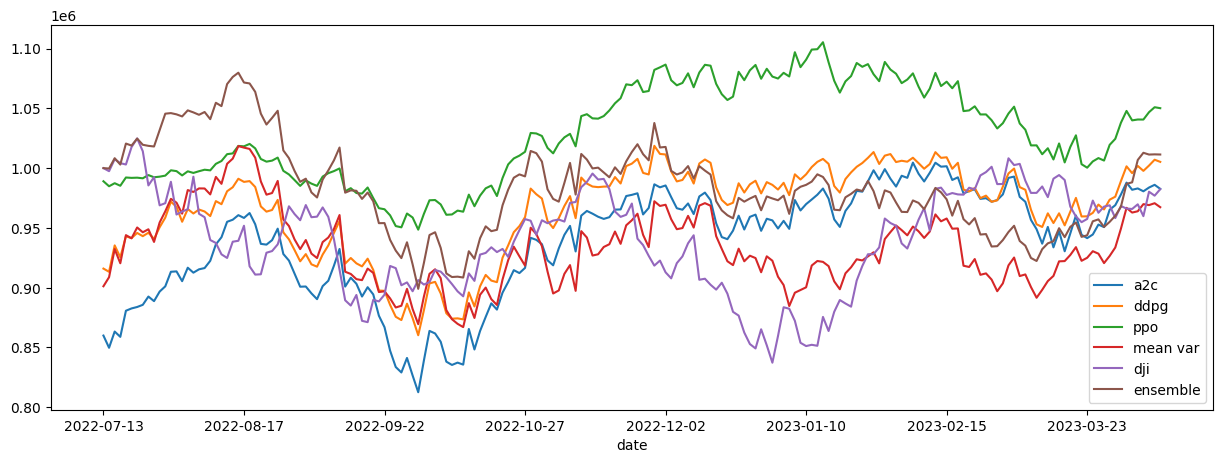

In [64]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,5)
plt.figure();
result.plot();